# Распознавание рукописных цифр

In [1]:
import pandas

import numpy as np
from matplotlib.pyplot import *
import os
from numpy import *
import random
%matplotlib inline

In [2]:
train_set = pandas.read_csv("Documents/digit/train.csv")
test_set = pandas.read_csv("Documents/digit/test.csv")

In [9]:
# Датасет слишком большой, чтобы обработать его за раз, поэтому будем работать со случайной выборкой
sample_size = 3100
rows = random.sample(train_set.index, sample_size)
pixels = train_set.columns[1:]
X_train = train_set[pixels].ix[rows]
y_train = train_set["label"].ix[rows]

### Визуализация данных

In [10]:
def reshapeToMatrix(arr):
    a = math.sqrt(len(arr))
    return arr.reshape((a, a))

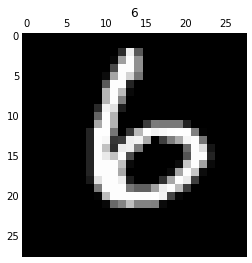

In [11]:
for i in range(1):
    matshow(reshapeToMatrix(X_train.values[i]), cmap=cm.gray)
    title(y_train.values[i])
    show()

Заметим, что вычисляя корень из величин пикселей изображения, мы фильтруем шум

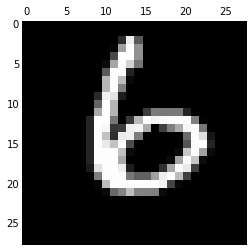

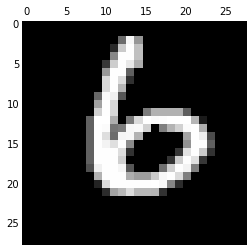

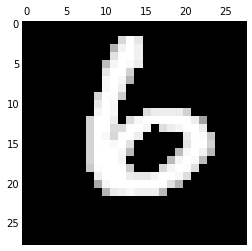

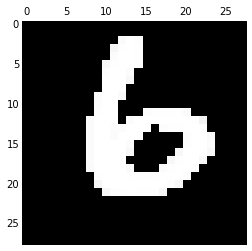

In [35]:
matrix_A = reshapeToMatrix(X_train.values[0])
matshow(matrix_A, cmap=cm.gray)
matshow(matrix_A**0.5, cmap=cm.gray)
matshow(matrix_A**0.1, cmap=cm.gray)
matshow(matrix_A**0.01, cmap=cm.gray)

### Машинное обучение

In [12]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation
from sklearn import metrics

Применим метод ближайших соседей

In [14]:
search_params = {
  'n_neighbors': arange(1, 70, 10),
  'metric': ['euclidean', 'minkowski', 'manhattan']
}

grid_searcher = GridSearchCV(KNN(), param_grid=search_params,\
                             cv=5, scoring='f1', n_jobs=1)
grid_searcher.fit(X_train, y_train)
print grid_searcher.best_score_
print grid_searcher.best_estimator_

0.913407928884
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_neighbors=1, p=2, weights='uniform')


Попробуем улучшить наш результат, расширяя тренировочную выборку путем добавления цифр и фильтруя изображения, сдвинутых на 1 пиксель. Для этого нам придется модифицировать процесс кросс-валидации, так как мы не можем использовать сдвинутые цифры на тесте.

Исходная выборка

In [44]:
clf = grid_searcher.best_estimator_
from sklearn.cross_validation import KFold
from sklearn.metrics import precision_score
kf = KFold(len(y_train), n_folds=5)
scores = []
for train, test in kf:
    X_test = X_train.values[test]
    y_test = y_train.values[test]
    X_cv_train = X_train.values[train]
    y_cv_train = y_train.values[train]

    clf.fit(X_cv_train, y_cv_train)
    predict = clf.predict(X_test)
    scores.append(precision_score(y_test, predict))
scores = np.array(scores)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2)) 

Accuracy: 0.9147 (+/- 0.0166)


Добавим фильтрацию

In [46]:
filter_value = 0.5
from sklearn.cross_validation import KFold
from sklearn.metrics import precision_score
kf = KFold(len(y_train), n_folds=5)
scores = []
for train, test in kf:
    X_test = X_train.values[test]**filter_value # фильтрация
    y_test = y_train.values[test]
    X_cv_train = X_train.values[train]**filter_value # фильтрация
    y_cv_train = y_train.values[train]

    clf.fit(X_cv_train, y_cv_train)
    predict = clf.predict(X_test)
    scores.append(precision_score(y_test, predict))
scores = np.array(scores)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))    


Accuracy: 0.9262 (+/- 0.0191)


Напишем функции для сдвига изображения

In [42]:
import numpy as np
from math import sqrt

def shift_up_down(row, shift):
    """Shifts image left by one pixel"""
    shifted_row = []
    weight = int(sqrt(row.size))
    for i in range(row.size):
        if (i + shift * weight) % weight == i % weight and i + shift * weight < row.size:
            shifted_row.append(row[i + shift * weight])
        else:
            shifted_row.append(0)
    return np.array(shifted_row)

def shift_left_right(row, shift):
    """Shifts image left by one pixel"""
    shifted_row = []
    weight = int(sqrt(row.size))
    for i in range(row.size):
        if (i + shift) // weight == i // weight:
            shifted_row.append(row[i + shift])
        else:
            shifted_row.append(0)
    return np.array(shifted_row)

Добавим сдвиг

In [43]:
from sklearn.cross_validation import KFold
from sklearn.metrics import precision_score
kf = KFold(len(y_train), n_folds=5)
scores = []
for train, test in kf:
    X_test = X_train.values[test]**filter_value # фильтрация
    y_test = y_train.values[test]
    X_cv_train = X_train.values[train]**filter_value # фильтрация
    y_cv_train = y_train.values[train]

    # Сдвиг
    shifted_down_X_train = np.apply_along_axis(shift_up_down, arr=X_cv_train, axis=1, shift=-1)
    shifted_left_X_train = np.apply_along_axis(shift_left_right, arr=X_cv_train, axis=1, shift=1)
    shifted_up_X_train = np.apply_along_axis(shift_up_down, arr=X_cv_train, axis=1, shift=1)
    shifted_right_X_train = np.apply_along_axis(shift_left_right, arr=X_cv_train, axis=1, shift=-1)


    X_cv_train = np.concatenate((X_cv_train, shifted_left_X_train, shifted_down_X_train,\
                                shifted_right_X_train, shifted_up_X_train), axis=0)
    y_cv_train = np.concatenate((y_cv_train, y_cv_train, y_cv_train, y_cv_train, y_cv_train), axis=0)
    
    clf.fit(X_cv_train, y_cv_train)
    predict = clf.predict(X_test)
    scores.append(precision_score(y_test, predict))

scores = np.array(scores)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.9414 (+/- 0.0101)


Как видно, благодаря сдвигу изображений и фильтрации, точность выросла на почти на 3%, что довольно неплохо.